In [25]:
from imu_dataset import IMUDataset
from model import IMUModelBig, IMUModelSmall
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.transforms as transforms
from pathlib import Path
from fvcore.nn import FlopCountAnalysis
import warnings
import torch.multiprocessing

torch.multiprocessing.set_sharing_strategy('file_system')
warnings.filterwarnings("ignore", category=UserWarning) 

In [26]:
VERSION = 'v9'
DATASET_PATH = "dataset"
EXPORT_PATH = Path(f"model_{VERSION}")
TRAIN_VALID_SPLIT = 0.8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 200
EVAL = "loss" # loss or acc

In [27]:
dataset = IMUDataset(base_path=DATASET_PATH)

train_set_size = int(len(dataset) * TRAIN_VALID_SPLIT)
valid_set_size = len(dataset) - train_set_size

train_dataset, valid_dataset = random_split(dataset, [train_set_size, valid_set_size])

len(train_dataset), len(valid_dataset)

Dataset means:  tensor([  0.2193,   3.6914,  -0.2452, -46.9606,  68.9107, -14.5513])
Dataset stds:  tensor([  2.3339,   4.2687,   2.2848, 410.9049, 330.7948, 386.3784])


(195, 49)

In [28]:
def show_sample(sample, label):
    sample = sample.T # from (6, 1000) to (1000, 6)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(IMUDataset.IDX_TO_CLASS[label], fontsize=16)
    axs[0].set_title("Accelerometer")
    axs[0].plot(sample[:, 0], label="x")
    axs[0].plot(sample[:, 1], label="y")
    axs[0].plot(sample[:, 2], label="z")
    axs[0].legend()
    axs[1].set_title("Gyroscope")
    axs[1].plot(sample[:, 3], label="x")
    axs[1].plot(sample[:, 4], label="y")
    axs[1].plot(sample[:, 5], label="z")
    axs[1].legend()
    plt.show()

In [29]:
def predict(model, tensor):
    tensor.to(DEVICE)
    model.to(DEVICE)

    model.eval()
    with torch.no_grad():
        start_time = time.time()
        output = model(tensor)
        ps = torch.exp(output)

        prob, idx = torch.max(ps, 1) # dim 0 is batch, dim 1 is probability distribution
        
        idx = idx[0].item() # item 0 of the batch
        prob = prob[0].item() # item 0 of the batch

        return IMUDataset.IDX_TO_CLASS[idx], prob, time.time() - start_time

In [30]:
def export(model, stats):
    EXPORT_PATH.mkdir(parents=True, exist_ok=True)

    # pytorch jit
    torch.jit.save(torch.jit.script(model), EXPORT_PATH / f"model_{VERSION}.pt")

    # onnx
    torch.onnx.export(model.cpu(),
                    dataset[0][0].to('cpu').unsqueeze(0), # dummy input
                    EXPORT_PATH / f"model_{VERSION}.onnx",
                    input_names = ['input'],
                    output_names = ['output'],
                    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}}) 

    # save stats
    with open(EXPORT_PATH / f"stats_{VERSION}.txt", "w") as f:
        f.write(stats)
    
    model.to(DEVICE)

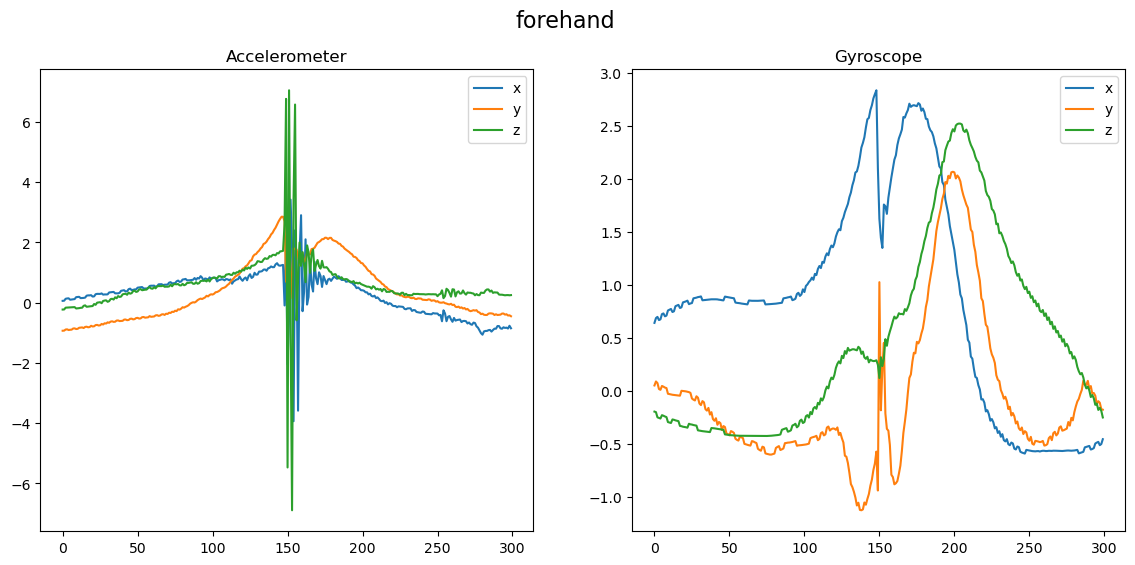

In [31]:
show_sample(*dataset[5])

In [32]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [33]:
model = IMUModelSmall()
model = model.to(DEVICE)

# init lazy modules
input_example = dataset[0][0].unsqueeze(0).to(DEVICE)
model(input_example)

# print model stats
flops = FlopCountAnalysis(model, input_example)

In [38]:
# print model stats
print(f"FLOPS: {flops.total()}")

print("Number of params:", sum(p.numel() for p in model.parameters()))

FLOPS: 28080
Number of params: 4356


In [35]:
loss = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

📍 Epoch: 000 | Train: 1.3845 (25.6410%) | Test: 1.3688 (22.4490%) | Time: 2.2021s
📍 Epoch: 001 | Train: 1.3595 (30.2564%) | Test: 1.3448 (26.5306%) | Time: 2.0596s
📍 Epoch: 002 | Train: 1.3224 (41.0256%) | Test: 1.3026 (46.9388%) | Time: 2.0347s
📍 Epoch: 003 | Train: 1.2581 (47.1795%) | Test: 1.2363 (51.0204%) | Time: 2.1982s
📍 Epoch: 004 | Train: 1.1861 (47.1795%) | Test: 1.1446 (51.0204%) | Time: 2.0165s
📍 Epoch: 005 | Train: 1.0673 (48.2051%) | Test: 1.0332 (53.0612%) | Time: 2.0742s
📍 Epoch: 006 | Train: 0.9448 (57.9487%) | Test: 0.8946 (67.3469%) | Time: 2.0125s
📍 Epoch: 007 | Train: 0.7919 (78.4615%) | Test: 0.7545 (89.7959%) | Time: 1.9671s
📍 Epoch: 008 | Train: 0.6309 (89.2308%) | Test: 0.6171 (93.8776%) | Time: 1.9151s
📍 Epoch: 009 | Train: 0.4883 (93.8462%) | Test: 0.4849 (95.9184%) | Time: 1.9575s
📍 Epoch: 010 | Train: 0.3545 (95.3846%) | Test: 0.3647 (97.9592%) | Time: 2.1333s
📍 Epoch: 011 | Train: 0.2577 (96.4103%) | Test: 0.2650 (97.9592%) | Time: 2.4317s
📍 Epoch: 012 | T

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Epoch: 036 | Train: 0.0203 (99.4872%) | Test: 0.0281 (100.0000%) | Time: 11.8992s
Epoch: 037 | Train: 0.0282 (99.4872%) | Test: 0.0288 (100.0000%) | Time: 1.9661s
Epoch: 038 | Train: 0.0306 (100.0000%) | Test: 0.0223 (100.0000%) | Time: 2.0198s
Epoch: 039 | Train: 0.0225 (98.9744%) | Test: 0.0179 (100.0000%) | Time: 2.0090s
📍 Epoch: 040 | Train: 0.0165 (100.0000%) | Test: 0.0155 (100.0000%) | Time: 1.9745s
Epoch: 041 | Train: 0.0203 (98.9744%) | Test: 0.0152 (100.0000%) | Time: 2.1103s
Epoch: 042 | Train: 0.0196 (98.9744%) | Test: 0.0211 (100.0000%) | Time: 2.1965s
Epoch: 043 | Train: 0.0167 (99.4872%) | Test: 0.0162 (100.0000%) | Time: 2.0457s
📍 Epoch: 044 | Train: 0.0152 (99.4872%) | Test: 0.0139 (100.0000%) | Time: 1.9950s
📍 Epoch: 045 | Train: 0.0125 (99.4872%) | Test: 0.0120 (100.0000%) | Time: 1.9691s
Epoch: 046 | Train: 0.0102 (100.0000%) | Test: 0.0125 (100.0000%) | Time: 1.9995s
Epoch: 047 | Train: 0.0128 (100.0000%) | Test: 0.0133 (100.0000%) | Time: 1.9962s
Epoch: 048 | Trai

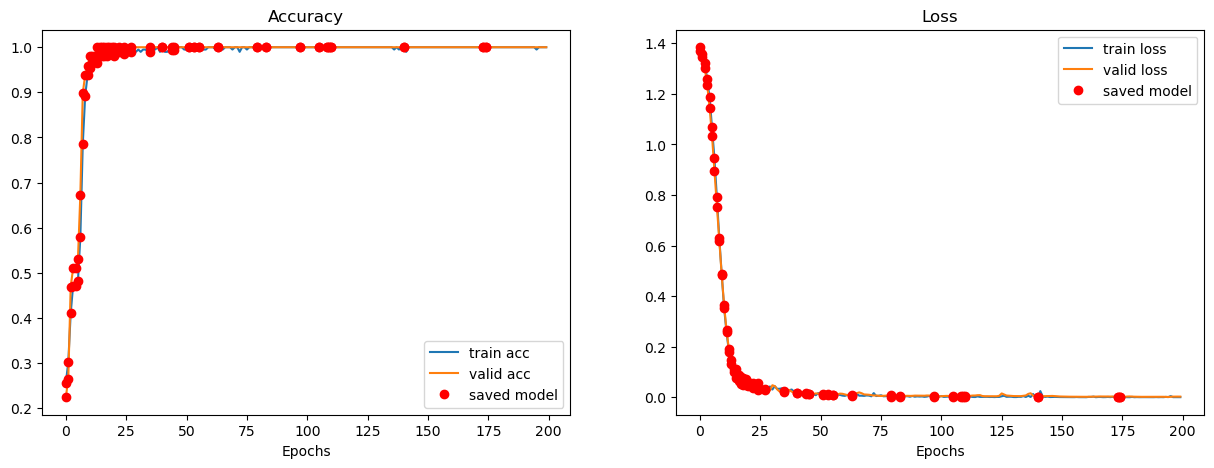

In [36]:
# training loop
history = []
saved_epochs = []

best_train_acc = 0.5
best_valid_acc = 0.5
best_train_loss = 1000
best_valid_loss = 1000

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # Set to training mode
    model.train()
    
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    
    for i, (inputs, labels) in enumerate(train_data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss_value = loss(outputs, labels)

        # Backpropagate the gradients
        loss_value.backward()

        # Update the parameters
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss_value.item() * inputs.size(0)

        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)


    # Validation - No gradient tracking needed
    with torch.no_grad():
    
        # Set to evaluation mode
        model.eval()
    
        for j, (inputs, labels) in enumerate(valid_data_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss_value = loss(outputs, labels)

            # Compute the total loss for the batch and add it valid_loss
            valid_loss += loss_value.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
                
            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)
        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_dataset) 
        avg_train_acc = train_acc/float(len(train_dataset))
        
        # Find average valid loss and valid accuracy
        avg_valid_loss = valid_loss/len(valid_dataset) 
        avg_valid_acc = valid_acc/float(len(valid_dataset))
        
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        
        better = False
        if EVAL == "loss":
            if avg_train_loss < best_train_loss and avg_valid_loss < best_valid_loss:
                better = True
        elif EVAL == "acc":
            if avg_train_acc >= best_train_acc and avg_valid_acc >= best_valid_acc:
                better = True

        saved = ""
        if better:
            best_train_acc = avg_train_acc
            best_valid_acc = avg_valid_acc
            best_train_loss = avg_train_loss
            best_valid_loss = avg_valid_loss

            saved_epochs.append(epoch)
            
            stats = f"Epoch: {epoch} | Train: {avg_train_loss:.4f} ({avg_train_acc*100:.4f}%) | Test: {avg_valid_loss:.4f} ({avg_valid_acc*100:.4f}%)"
            export(model, stats)
            saved = "📍 "
        
        print(f"{saved}Epoch: {epoch:03d} | Train: {avg_train_loss:.4f} ({avg_train_acc*100:.4f}%) | Test: {avg_valid_loss:.4f} ({avg_valid_acc*100:.4f}%) | Time: {epoch_end-epoch_start:.4f}s")


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot([h[2] for h in history], label='train acc')
axs[0].plot([h[3] for h in history], label='valid acc')
axs[0].plot(saved_epochs, [h[2] for i, h in enumerate(history) if i in saved_epochs], 'ro', label='saved model')
axs[0].plot(saved_epochs, [h[3] for i, h in enumerate(history) if i in saved_epochs], 'ro')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot([h[0] for h in history], label='train loss')
axs[1].plot([h[1] for h in history], label='valid loss')
axs[1].plot(saved_epochs, [h[0] for i, h in enumerate(history) if i in saved_epochs], 'ro', label='saved model')
axs[1].plot(saved_epochs, [h[1] for i, h in enumerate(history) if i in saved_epochs], 'ro')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

plt.show()

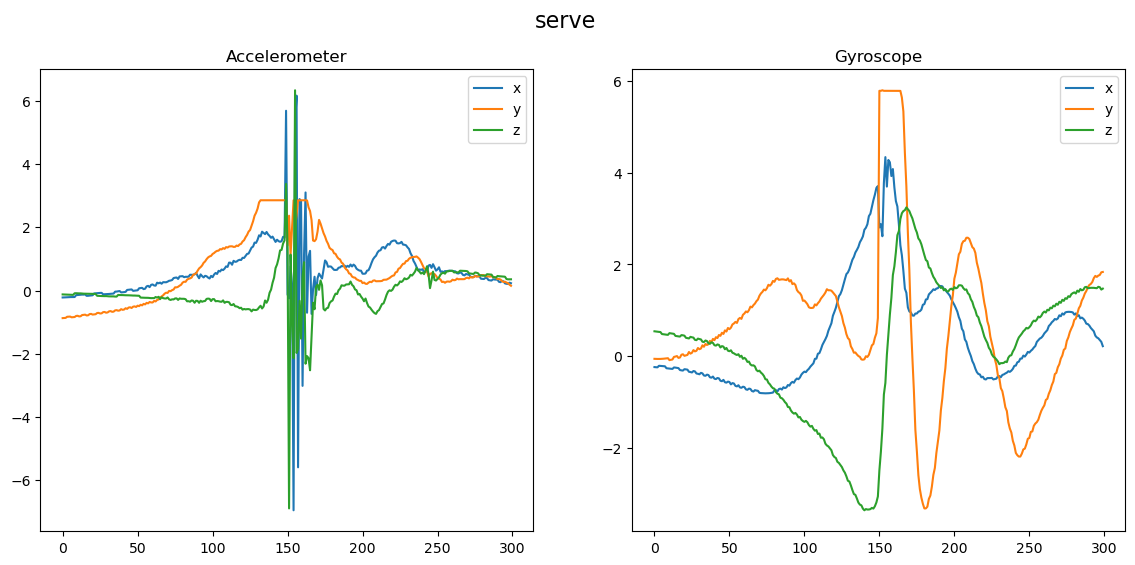

Predicted: serve(100.0%), inference time: 0.54ms


In [45]:
# test prediction
sample = dataset[209]
tensor = sample[0].to('cpu').unsqueeze(0) # add batch dim
show_sample(*sample)

prediction, prob, inf_time = predict(model, tensor)
print(f"Predicted: {prediction}({prob*100:.1f}%), inference time: {inf_time*1000:.2f}ms")
